# Отчёт

# Поиск плохих данных

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json,os
import pandas as pd

Выделение имен пустых или близких к пустым файлов, файлов с пропусками данных

In [248]:
prop=[] #имена файлов с пропусками
zero=[] #имена файлов с нагрузкорой 0
semiZero=[] #имена файлов с большим колличеством нулевых значений
normal=[]
full=[]
full0=[]
files=os.listdir(path="flink_metric_data_new")
for i in files:
    name=f"flink_metric_data_new/"+i
    with open(name) as f:
        data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
    df.drop('unit',axis=1,inplace=True)
    df.head()
    n=0
    time=df['timestamp']
    tamp = time[1]-time[0]
    for j in time:
        if(j != time[0] + tamp*n): #проверка на наличие пропусков
            prop.append(i)
            break
        n+=1
    average = list(df['average'])
    count=average.count(0)
    l=len(average)
    if(count == l):
        zero.append(i)
    elif(l-count<300):
        semiZero.append(i)        
    else:
        normal.append(i)
    if(l==2017 and count==0):
        full.append(i)
    if(l==2017):
        full0.append(i)
    
    

            

In [71]:
print(len(semiZero),len(zero),len(normal))

75 326 389


Пример файла с малым колличеством не нулевых значений

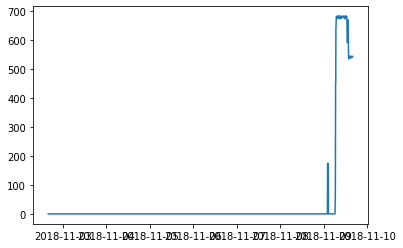

In [80]:
name=f"flink_metric_data_new/"+semiZero[10]
with open(name) as f:
    data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
df.drop('unit',axis=1,inplace=True)
df.head()
df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')
plt.plot(df['timestamp'],df['average'])


Пример данных с потерянным значением

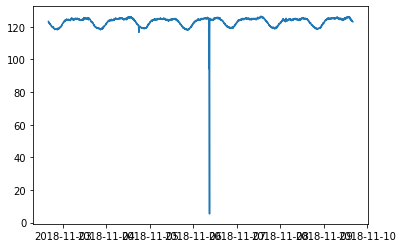

In [99]:
name=f"flink_metric_data_new/"+prop[1]
with open(name) as f:
    data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
df.drop('unit',axis=1,inplace=True)
df.head()
df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')
plt.plot(df['timestamp'],df['average'])


# Сглаживание шума увилечением временного шага

Функция возвращающая по данному набору данных, сжатый.

In [144]:
def lowTime(k,df):
    newL = int(len(df)/k) #колличество новых временных интервалов
    newAverage = [] #список новых значений
    newTimestamp = [] #спимок новых временных отметок
    for i in range(newL):
        newAverage.append(np.sum(df['average'][i*k:i*k+k]))
        newTimestamp.append(df['timestamp'][k+i*k])
    return  pd.DataFrame(data = {'average': newAverage, 'timestamp': newTimestamp})

График при стандартном разбиение

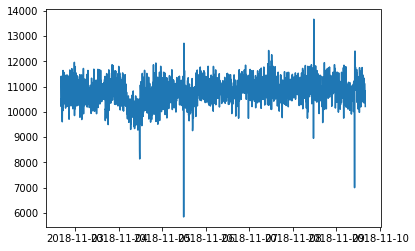

In [508]:
name=f"flink_metric_data_new/"+full[19]
with open(name) as f:
    data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
df.drop('unit',axis=1,inplace=True)
df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')
plt.plot(df['timestamp'],df['average'])

Разбиение по часам

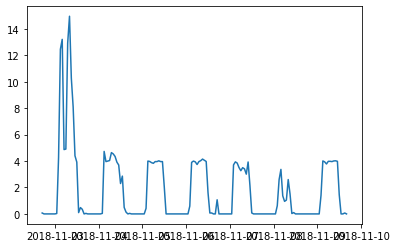

In [149]:
newDf=lowTime(12,df) #пример работы функции для обьединение интервалов в часовые
plt.plot(newDf['timestamp'],newDf['average'])

# Кластерезация

In [151]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Для удобства анализа кластеризации сделаем функцию выводящую график всех обьектов попавших в один кластер

In [304]:
def view(filesList, data, clusterName, Graphcount):
    clusterList=np.where(data['cluster'] == clusterName)[0]
    n=0
    for i in clusterList:
        name=f"flink_metric_data_new/"+filesList[i]
        with open(name) as f:
            data = json.load(f)
            df = pd.DataFrame(data['datapoints'])
        df.drop('unit',axis=1,inplace=True)
        df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')
        plt.plot(df['timestamp'],df['average'])
        n+=1
        if(n==Graphcount):
            break

 Попытка использования всех значений нагрузки ряда для предсказания с помошью kmeans

In [249]:
dat = []
for i in full0:
    name=f"flink_metric_data_new/"+i
    with open(name) as f:
        data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
    df.drop('unit',axis=1,inplace=True)
    dat.append(df['average'])


In [294]:
fulldata = pd.DataFrame(dat)
    


IndentationError: unexpected indent (<ipython-input-294-6cde400e7608>, line 2)

In [251]:
scaler = StandardScaler()
X = scaler.fit_transform(fulldata)


In [320]:
n_clusters = 10
km = KMeans(n_clusters=n_clusters)
fulldata['cluster'] = km.fit_predict(X)
fulldata.head()

,0,1,2,3,4,5,6,7,8,9,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,cluster
average,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
average,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
average,8629.29,8906.97,8746.82,8843.66,8778.79,8805.89,8906.59,9266.97,9611.46,9116.48,...,4052.38,4167.89,4142.28,4149.90,4128.89,4208.52,4101.66,4161.39,4288.55,4
average,8632.11,8917.07,8753.14,8846.14,8785.00,8808.75,8908.14,9260.00,9609.75,9122.21,...,4052.52,4167.29,4142.34,4149.52,4128.86,4207.86,4101.55,4161.68,4290.59,4
average,3400.79,3623.41,3626.96,3524.62,3633.38,3643.93,3512.07,3624.07,3613.57,3584.72,...,3496.72,3589.96,3496.28,3550.52,3443.29,3630.62,3532.97,3609.39,3429.66,4


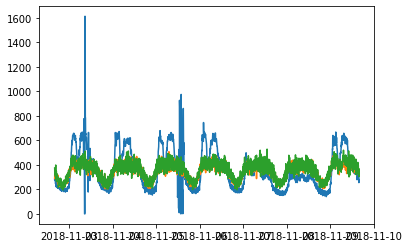

In [517]:
view(full0,fulldata,4,6)

Возможно резлуьтат получиться улучшить снизив шум

In [354]:
dat1 = []
for i in full0:
    name=f"flink_metric_data_new/"+i
    with open(name) as f:
        data = json.load(f)
    df = pd.DataFrame(data['datapoints'])
    df.drop('unit',axis=1,inplace=True)
    newdf=lowTime(12,df)
    dat1.append(newdf['average'])


In [355]:
fulldata1 = pd.DataFrame(dat1)
    

In [356]:
scaler = StandardScaler()
X = scaler.fit_transform(fulldata1)


In [357]:
n_clusters = 10
km = KMeans(n_clusters=n_clusters)
fulldata1['cluster'] = km.fit_predict(X)
fulldata1.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,cluster
average,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
average,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
average,106658.23,105246.47,106548.94,105615.83,104496.08,104905.53,105616.57,104847.77,104681.83,104692.84,...,50037.69,50005.60,49941.72,51286.97,51007.82,51738.00,51670.14,49935.19,49969.38,4
average,106692.15,105235.02,106568.89,105610.63,104487.93,104903.95,105597.05,104875.37,104699.80,104695.77,...,50040.03,50007.68,49940.45,51296.89,50995.71,51744.18,51674.85,49930.84,49967.03,4
average,43049.81,43281.91,43184.45,43481.84,43271.76,43119.60,43139.84,43366.72,43506.14,43673.36,...,40986.06,42656.50,42626.54,42156.24,42396.56,41828.50,41890.09,41429.20,42017.59,4


In [359]:
def view1(filesList, data, clusterName, Graphcount):
    clusterList=np.where(data['cluster'] == clusterName)[0]
    n=0
    for i in clusterList:
        name=f"flink_metric_data_new/"+filesList[i]
        with open(name) as f:
            data = json.load(f)
            df = pd.DataFrame(data['datapoints'])
        df.drop('unit',axis=1,inplace=True)
        df=lowTime(12,df)
        df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')
        plt.plot(df['timestamp'],df['average'])
        n+=1
        if(n==Graphcount):
            break

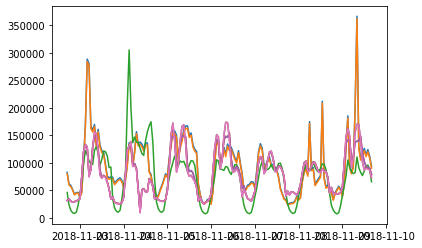

In [542]:
view1(full0,fulldata1,8,10) #результаты кластеризации при уменьшении шума

Попытка уменьшить размерность и применить DBscan

In [199]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

In [398]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
print(X_principal.head()) 

         P1        P2
0 -1.867296  0.305329
1 -1.867296  0.305329
2  8.177014 -1.452102
3  8.177040 -1.452223
4  4.852360 -1.857298


In [492]:
db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal) 
labels = db_default.labels_ 


In [507]:
!pip install mpld3

  Created wheel for mpld3: filename=mpld3-0.5.1-py3-none-any.whl size=364069 sha256=d04a1dfb3202cb6dea9829531ec6feaef9f26ecefa49462ee52f8da602856ba1
  Stored in directory: c:\users\muxsu\appdata\local\pip\cache\wheels\b9\36\27\d61b9f1327012961fa31f05a20b190f836dd3fcb1c0264177b
Successfully built mpld3


In [545]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

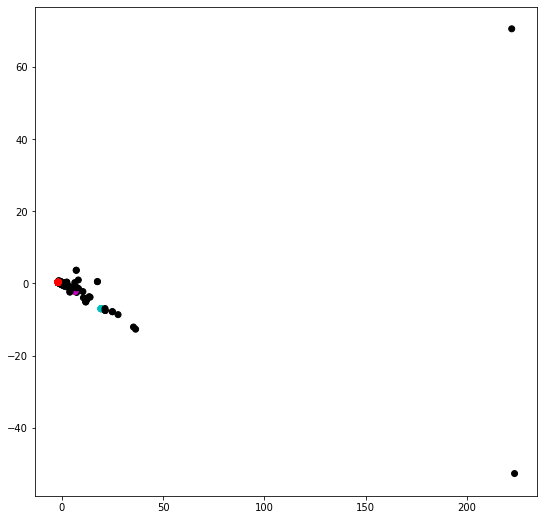

In [546]:

colours1 = {} 
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[6] = 'm'
colours1[7] = 'm'
colours1[8] = 'm'
colours1[-1] = 'k'
cvec=[]
for i in labels:
    cvec.append(colours1[i])
plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'],c = cvec) 
plt.show() 

In [438]:
fulldata2=fulldata
#labels={'cluster':labels}
#labels=pd.DataFrame(labels)
fulldata2['cluster']=labels


Сравнение рядов из одного кластера

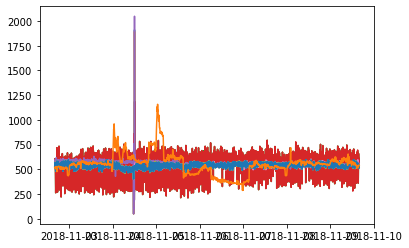

In [547]:
view(full0,fulldata2,2,30) #графики одного класса

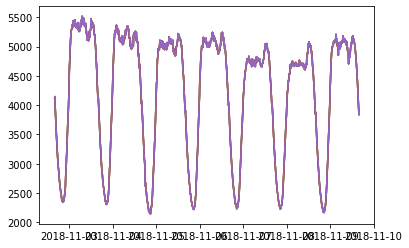

In [534]:
view(full0,fulldata2,6,10) #графики еше одного класса